In [29]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import numpy as np
from scipy.spatial import distance_matrix

import astropy.units as u
import os
import glob
# This makes nice big plots for matplotlib
import matplotlib as mpl
params = {'font.size': 14,
          'figure.figsize': (15.0, 8.0),
          'lines.linewidth': 2.,
          'lines.markersize': 15,
          'animation.embed_limit': 2048,
          }
mpl.rcParams.keys()
mpl.rcParams.update(params)
np.set_printoptions(suppress=True)

import sunpy.map

data_dir = os.path.abspath("/home/lazar/Fak(s)/AF/prakse/SDSA/data")

cont_list = sorted(glob.glob(os.path.join(
    data_dir, "3481_11923_SHARP_CEA_enhanced_norm/*enhanced_normalized*")))


magnetic_data_dir = os.path.join(
    data_dir, "3481_11923_SHARP_CEA_upscaled_magnetic_data")
Br_list = sorted(glob.glob(os.path.join(
    magnetic_data_dir, "*Br*")))
Bp_list = sorted(glob.glob(os.path.join(
    magnetic_data_dir, "*Bp*")))
Bt_list = sorted(glob.glob(os.path.join(
    magnetic_data_dir, "*Bt*")))
patches_dir = os.path.join(data_dir, "3481_11923_SHARP_CEA_patches")
patches_list = sorted(glob.glob(os.path.join(patches_dir, "*patches*")))

In [34]:
def map_between_images(centers_1, centers_2, r_search=11):
    '''
    C1 - Matrix of centers that get_patches_and_vectors returns
    C2 - Matrix of centers that get_patches_and_vectors returns for second image
    r_search - search radius for nearest neighbour in pixel distance
    - it search for 
    
    returns:
    mapper - Array of tuples containing mappings between two images
    first element of tuple is patch on first image
    '''
    mapper = [] #Fucking hate doing append and empty array creation!
    
    #if centers_1 have no entries
    #Return empty array
    if centers_1.ndim == 0:
        return mapper
    
    #If it has something, extract X and Y coordinates
    C1 = centers_1[:,0:2]
    
    #if centers_2 have no entries
    #we know that everything from first image dissapeared
    #so we return tuples (cent_1, 'X')
    if centers_2.ndim == 0:
        #i know that center_1.ndim != 0
        #bcz of above if
        for i in range(C1.shape[0]):
            mapper.append((i, 'X'))
        return mapper
    
    C2 = centers_2[:,0:2]
    #Calculate distance matrix
    DM = distance_matrix(C1,C2)
    
    #Loop trough all rows of cost matrix 
    for first in range(DM.shape[0]):
        #if in that row, we have entries that are smaller than r_search
        #we put it in tuple
        second = (DM[first] < r_search).nonzero()[0]
        #If there is no entries, mark it as NOT MAPPED (disapeared or whatever)
        
        
        if second.shape[0] == 0:
            #print("ovaj nije mapiran")
            mapper.append((first, 'X'))
            #Skip that row for executing on code bellow
            continue
        #If we have multiple values (or signle, we dont care)
        #mark those as MAPPED
        for i in second:
            mapper.append((first,i))
            
    #I need one more check
       
    #Imagine you have two points in C1 and two in C2
    #Distance C1_1 to C2_1 and C2_2 are both < r_search
    #This will say:
    #"ok, C1_1 is mapped into both C2_1 and C2_2 and C1_2 also maps into C2_1 and C2_2"
        
            
    return mapper

In [35]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
#This so i can fetch this function which is in directory above
from region_fill_master_wrap import get_patches_and_vectors
from skimage.feature import match_descriptors

In [36]:
#LOAD DATA
#for start in range(600,605):
start = 600
many = 5
plim = 20 #discard everything below 20 pix
#Saves memory, maybe you will want also real maps loaded, but no need AFAIK
I_maps = cont_list[start:start+many]
Bx_maps = Bp_list[start:start+many]
By_maps = Bt_list[start:start+many]
Bz_maps = Br_list[start:start+many]
#Dont load it in for, hate doing that, create lambda wrapper
g = lambda i,x,y,z: get_patches_and_vectors(sunpy.map.Map(i), sunpy.map.Map(x), 
                                            sunpy.map.Map(y), sunpy.map.Map(z), 
                                            pixel_limit=plim, floodfill=4)
DATA = np.asarray(list(map(g, I_maps, Bx_maps, By_maps, Bz_maps)))

Using 4 directions search map on HMI hmi 2013-12-13 11:10:09
Using 4 directions search map on HMI hmi 2013-12-13 11:22:09
Using 4 directions search map on HMI hmi 2013-12-13 11:34:09
Using 4 directions search map on HMI hmi 2013-12-13 11:46:09
Using 4 directions search map on HMI hmi 2013-12-13 11:58:09


In [37]:
CENTERS = DATA[:,0]
MAPS = DATA[:,1]
#print(MAPS)
mapper = map_between_images(CENTERS[0],CENTERS[1])
print(CENTERS[0][:,0:2])

[[1117.70588235  593.78151261]
 [1106.08547009  618.68376068]
 [1080.60606061  653.24242424]
 [ 849.97590361  664.98795181]
 [ 965.46666667  668.61666667]
 [ 859.49101796  680.16167665]]


(1117.7478260869566, 594.0)
(1117.9349593495936, 593.7967479674796)
0 0
1 1
2 3
3 3
4 4
[(0, 0), (1, 1), (2, 3), (3, 3), (4, 4)]


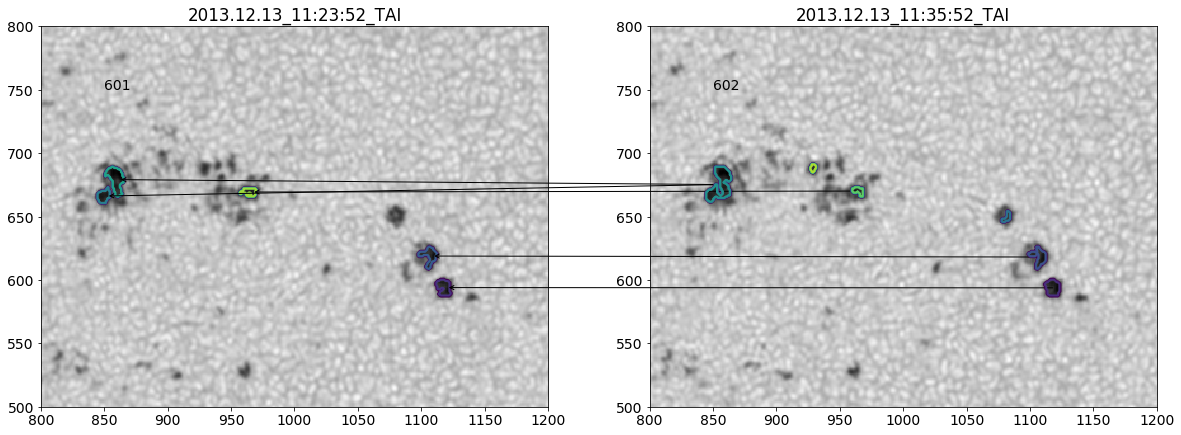

In [38]:
from matplotlib.patches import ConnectionPatch
#start = 600
#many = 1
wir = 1
mapper = map_between_images(CENTERS[wir],CENTERS[wir+1])

I = sunpy.map.Map(cont_list[start+wir])
I2 = sunpy.map.Map(cont_list[start+wir+1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
#axes[0] = plt.subplot(1, 2, 1)
ax1.imshow(I.data, cmap='gray', origin='lower')
ax1.set_title(I.meta['T_OBS'])
ax1.contour(MAPS[wir])
ax1.text(850,750,str(start+wir))
ax1.set_xlim([800,1200])
ax1.set_ylim([500,800])


C1 = CENTERS[wir][:,0:2]
C2 = CENTERS[wir+1][:,0:2]

# Draw an arrow between the same point in data coordinates,
# but in different axes.
#map_between_images
#WHAT PATCH!
ptch = 0
#which region on first?
a1 = mapper[ptch][0]
#which region on second?
a2 = mapper[ptch][1]
#print(a1,a2)
#get xy data from first patch
xya = (C1[a1,0], C1[a1,1])
#get xy data from second patch
xyb = (C2[a2,0], C2[a2,1])
print(xya)
print(xyb)

for p1, p2 in mapper:
    print(p1,p2)
    if p1 == 'X' or p2 == 'X':
        continue
    xya = (C1[p1,0], C1[p1,1])
    xyb = (C2[p2,0], C2[p2,1])
    coordsA = "data"
    coordsB = "data"
    con = ConnectionPatch(xyA=xyb, xyB=xya, coordsA=coordsA, coordsB=coordsB,
                      axesA=ax2, axesB=ax1,
                      arrowstyle="->", shrinkB=5)
    ax2.add_artist(con)



#axes[1] = plt.subplot(1, 2, 2)
ax2.set_xlim([800, 1200])
ax2.set_ylim([500, 800])
ax2.imshow(I2.data, cmap='gray', origin='lower')
ax2.set_title(I2.meta['T_OBS'])
ax2.text(850,750,str(start+wir+1))
ax2.contour(MAPS[wir+1])
print(mapper)
#plt.savefig('4.jpg')